# **Datasets that were used for this project**

All datasets have been taken from Kaggle.com and are free to use by anyone.

> The first dataset is Fruits 360: https://www.kaggle.com/moltean/fruits

> The second dataset that is used is Waste dataset: https://www.kaggle.com/szdxfkmgnb/waste-classification

> The third dataset that is used is called Garbage Classification (12 classes) dataset: https://www.kaggle.com/mostafaabla/garbage-classification?fbclid=IwAR06p8i1Ct4-XUPC8WiYsPozvibMeHAmuHZ5iW3Zi3BVtWvLNmEk-rzBjnA







# **Google Colab and Kaggle Union**
It is not necessary to unite Google Colab and Kaggle, but I am uniting it for the fact that downloading the datasets and uploading them in the Google Colab is going to be much faster than in Google Drive.

> https://www.kaggle.com/general/74235





In [ ]:
! pip install -q kaggle

In [ ]:
 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evaldasvainaviius","key":"8d0d9c77b4504ac688383a7b9f21d27f"}'}

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d evaldasvainaviius/final-year-project
! unzip final-year-project

In [ ]:
! kaggle datasets download -d moltean/fruits
! unzip fruits.zip

In [ ]:
#Importing the necessary libraries for the code

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

# Printing all file names that exist in fruits-360 folder
# In addition, getting all the subfolders from Training folder (which will be all the classes of fruits)

#data_dir = '/content/Dataset(Wastes)'
data_dir = '/content/fruits-360'
print('Folders :', os.listdir(data_dir))
print("******************************************************************************")
classes = os.listdir(data_dir + "/Training")
print('There are: ' + str(len(classes)) + ' classes. ', classes)

Folders : ['Training', 'Test', 'LICENSE', 'test-multiple_fruits', 'papers', 'readme.md']
******************************************************************************
There are: 140 classes.  ['Lychee', 'Plum 3', 'Pear Kaiser', 'Pomegranate', 'Pear Abate', 'Cherry 1', 'Tomato 4', 'Mandarine', 'Banana Lady Finger', 'Pear Monster', 'Apple Red 3', 'Beetroot', 'Strawberry', 'Salak', 'Peach 2', 'Grapefruit Pink', 'Pepper Red', 'Kohlrabi', 'Apple Braeburn', 'Potato Red', 'Tomato Maroon', 'Peach Flat', 'Potato White', 'Tomato Cherry Red', 'Tomato Yellow', 'Chestnut', 'Apple Golden 2', 'Granadilla', 'Pepper Green', 'Cucumber Ripe', 'Pepper Orange', 'Pear Williams', 'Cantaloupe 1', 'Apple Golden 1', 'Apple Golden 3', 'Banana Red', 'Kaki', 'Lemon', 'Papaya', 'Mango', 'Grapefruit White', 'Cocos', 'Tomato 1', 'Apple Red Yellow 1', 'Orange', 'Corn Husk', 'Peach', 'Cantaloupe 2', 'Apple Red 2', 'Pineapple', 'Apple Granny Smith', 'Grape White 3', 'Grape Pink', 'glass', 'Quince', 'Plum', 'Lemon Meyer

In [ ]:
#Getting the total amount of images in Training folder and in Test folder

transforming = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

dataset = ImageFolder(data_dir + '/Training', transform=transforming)
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=transforming)
print('Size of test dataset :', len(test))

Size of training dataset : 80731
Size of test dataset : 30179


In [ ]:
# view one image shape of the dataset.
img, label = dataset[599]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
1


Label:  Apple Crimson Snow (1)


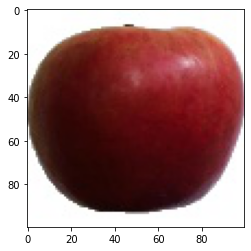

In [ ]:
# function for showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_image(*dataset[599])

# **Google Colab and GPU usage**

Google Colab allows each free user to use its own installed GPU for everyone. It also has a very powerful CPU, but when there is a need to complete heavy tasks using GPU is much more efficient. Therefore, for the sake of this project GPU will be used to complete each task, where possible.

The following code below, checks if the Google Colab's GPU is allowed and if the program can access it. If it can, then we switch the application runtime to use GPU instead of CPU.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

# **Preparing data for training, validation and testing**

Data preparation is taking place in this section. The data is splitted into three parts: Training, Validation and Testing.

In [ ]:
torch.manual_seed(20) #Torch manual seed is acting like a saving point, with the provided number the output of the program is always going to be the same
val_size = len(dataset)//5 #Validation data size is determined by 
train_size = len(dataset) - val_size
print(val_size)

16146


In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(64585, 16146)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_ds,
                          batch_size,
                          shuffle= True, 
                          num_workers=4, 
                          pin_memory=True)

val_loader = DataLoader(val_ds,
                        batch_size*2,
                        num_workers=4,
                        pin_memory=True)

test_loader = DataLoader(test,
                         batch_size*2,
                         num_workers=4,
                         pin_memory=True)

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
input_size = 3*100*100
output_size = len(classes)

# **Logistic Regression Model**

The following code below shows the use of Logistic Regression model in Pytorch with the given dataset.

In [ ]:
# Logistic regression model
model = nn.Linear(input_size, output_size)

In [ ]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([138,  31,  25,  95, 128,  87, 108,  22,   3, 138,  14, 135,   6, 139,
         65,  30, 113,  23,  32, 119, 138,   6,  31,  12,  44,  27,  21, 113,
        104,  41,  57,  29,  21,   2,  78,  79, 135,  28, 138,  25,  99,  72,
         84,  92,  84,  10, 121,  61, 137, 138,  84, 127,  18,   9,  13,  10,
         33, 127,  96, 134,  40,  54, 106,  53, 124,  21,  76, 108,  27,  72,
         54, 116,  18,  56,  57,  40,  16,  28,  87, 134,  45,  16, 104, 102,
        104,  79, 137,  88, 137, 125,  84,  71,   2,  23,  51,  82,  75,  90,
         74,  82, 105,  34,  92, 138, 138, 120, 100,  42, 110,  25,  73, 138,
         29,  69,  37,   2,  29, 109,  57,  60, 128, 134, 106, 108,  25,  55,
         62, 100])
torch.Size([128, 3, 100, 100])


RuntimeError: ignored

In [ ]:
images.shape

torch.Size([128, 3, 100, 100])

In [ ]:
images.reshape(batch_size, 30000).shape

torch.Size([128, 30000])

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
loss_fn = F.cross_entropy

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 30000)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = LogisticRegressionModel()


In [ ]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.00592041015625, 'val_loss': 5.034319877624512}

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.00592041015625, 'val_loss': 5.034319877624512}]

In [ ]:
history = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 3.2710, val_acc: 0.3877
Epoch [1], val_loss: 2.6248, val_acc: 0.5426
Epoch [2], val_loss: 2.2324, val_acc: 0.6403
Epoch [3], val_loss: 1.9594, val_acc: 0.6769
Epoch [4], val_loss: 1.7577, val_acc: 0.7095


In [ ]:
history = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6105, val_acc: 0.7301
Epoch [1], val_loss: 1.4974, val_acc: 0.7439
Epoch [2], val_loss: 1.3898, val_acc: 0.7635
Epoch [3], val_loss: 1.3080, val_acc: 0.7717
Epoch [4], val_loss: 1.2362, val_acc: 0.7914


In [ ]:
history = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1737, val_acc: 0.7971
Epoch [1], val_loss: 1.1194, val_acc: 0.8051
Epoch [2], val_loss: 1.0798, val_acc: 0.8080
Epoch [3], val_loss: 1.0332, val_acc: 0.8193
Epoch [4], val_loss: 0.9937, val_acc: 0.8255


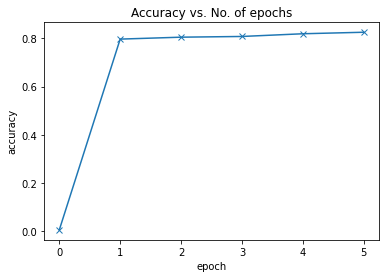

In [ ]:
history = [result0] + history
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 12 , Predicted: 12


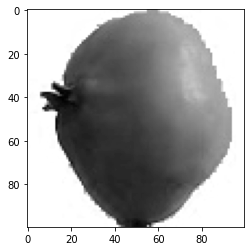

In [ ]:
img, label = test[2000]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DataLoader(dataset, batch_size=256)
result = evaluate(model, test_loader)
result


# **FeedForward Neural Network (FNN)**

In [ ]:
#The Base step is the same in every algorithm, it will always include training_step, validation_step, validation_epoch_end
#and epoch_end! The code will always look the same for every algorithm in its base case! No changes should be made unless
#there is a need, but most of the times there is no need to do that!
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#This is also the base of all algorithms, the same as the one above with ImageClassificationBase! 
#It should only be modified if necessary, but in most cases it is not!

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*100*100
output_size = len(classes)

In [ ]:
class ModelFNN(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [ ]:
model = to_device(ModelFNN(input_size, output_size), device)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.00543212890625, 'val_loss': 4.941213607788086}]

In [ ]:
history += fit(7, 0.01, model, train_loader, val_loader)


Epoch [0], train_loss: 4.6738, val_loss: 4.1947, val_acc: 0.0767



Epoch [1], train_loss: 3.5999, val_loss: 3.0368, val_acc: 0.1377



Epoch [2], train_loss: 2.7323, val_loss: 2.2596, val_acc: 0.3282



Epoch [3], train_loss: 1.9447, val_loss: 1.8388, val_acc: 0.4290



Epoch [4], train_loss: 1.4610, val_loss: 1.5548, val_acc: 0.5045



Epoch [5], train_loss: 1.1186, val_loss: 0.8700, val_acc: 0.7265



Epoch [6], train_loss: 0.9343, val_loss: 0.7086, val_acc: 0.7849


In [ ]:
history += fit(8, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 0.5653, val_loss: 0.5543, val_acc: 0.8442



Epoch [1], train_loss: 0.5289, val_loss: 0.5303, val_acc: 0.8421



Epoch [2], train_loss: 0.5091, val_loss: 0.5143, val_acc: 0.8510



Epoch [3], train_loss: 0.4930, val_loss: 0.4996, val_acc: 0.8566



Epoch [4], train_loss: 0.4793, val_loss: 0.4849, val_acc: 0.8585



Epoch [5], train_loss: 0.4667, val_loss: 0.4738, val_acc: 0.8659



Epoch [6], train_loss: 0.4552, val_loss: 0.4631, val_acc: 0.8644



Epoch [7], train_loss: 0.4449, val_loss: 0.4546, val_acc: 0.8697


In [ ]:
history += fit(3, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 0.4356, val_loss: 0.4450, val_acc: 0.8701



Epoch [1], train_loss: 0.4268, val_loss: 0.4350, val_acc: 0.8739



Epoch [2], train_loss: 0.4182, val_loss: 0.4250, val_acc: 0.8809


In [ ]:
evaluate(model, test_loader)

{'val_acc': 0.7425172328948975, 'val_loss': 0.8920179605484009}

# **Convolutional Neural Network (CNN)**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, 131))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CnnModel()
model.cuda()

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
history=[evaluate(model, val_loader)]
history

RuntimeError: ignored

In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
history += fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)

In [ ]:
evaluate(model, test_loader)

{'val_acc': 0.6690666079521179, 'val_loss': 2.535784959793091}

In [ ]:
def predict_image(img, label):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, pred = torch.max(yb, dim = 1)
  return dataset.classes[preds[0].item()]

In [ ]:
img, label = test[0]
plt.imshow(img.permute(1,2,0))
print ('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))